In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts

n0 = 0.16 #MeV/fm^3
pi = np.pi
MeV_to_km = 1.323e-6

In [4]:
EOS_small = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

We are going to extend this table through the speed of sound. We are using the speed of sound because of it's definition:

$$ c_s^2 = \frac{\partial p(\epsilon)}{\partial \epsilon} $$

The mechanics will work like Ingo et. al. where we step the baryon density, $n$, by a small $\Delta n$,

$$ n_{i+1} = n_i + \Delta n $$

where $i$ is the index of our data array. Then we use the speed of sound, $c_s$, and a thermodynamic identity to get the energy density and pressure.

$$
\begin{align}
    \epsilon_{i+1} &= \epsilon_i + \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)\\
    p_{i+1} &= p_i + c_s^2(n_i) \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)
\end{align}
$$
    
We will be defining our speed of sound curve in this notebook by specifying its value at a number of points and just connecting the two with linear segments. The speed of sound (in units where c=1) must be between 0 and 1 to keep causality.

To begin, let's get the speed of sound in the range we already have (n < 2n0).

In [5]:
n = EOS_small[:,0] 
p = EOS_small[:,1] 
e = EOS_small[:,2] 

# derivative of pressure wrt energy
dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)

#definition of speed of sound
c_s_2n0 = np.sqrt(1/dp_de(p[-1]))
print(n)

[4.00000001e-15 4.73000011e-15 4.75999990e-15 ... 3.19600000e-01
 3.19800000e-01 3.20000000e-01]


In [6]:
def sample_cs(num_points, max_n, n_start, cs_start):
    
    # sample random points in density
    epsilon = 1e-17
    loc_n = n_start + epsilon #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)
    
    # sample speeds of sound
    sample_cs = sts.uniform.rvs(size=num_points)
    
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    c_0 = cs_start*np.ones(1)
    cs = np.append(c_0, sample_cs)
    
    return ns, cs

[1.33522901e-01 2.84014279e-02 2.65685664e-02 1.61566282e-01
 6.69147335e-01 5.41472794e-04 3.14657145e-01 1.93404364e-01
 9.14105881e-02]


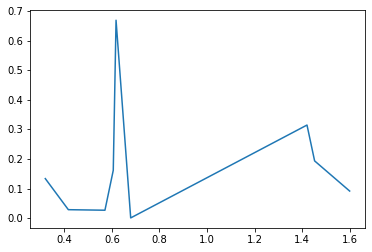

In [7]:
num_points = 8
n_start = n[-1]
max_n = 10*n0

ns, cs = sample_cs(num_points, max_n, n_start, c_s_2n0)

cs2_lin = scipy.interpolate.interp1d(ns, cs**2)

print(cs**2)

plt.plot(ns, cs2_lin(ns))

In [10]:
def extend_EOS_cs(n_step, cs2_func):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        if cs2_func(EOS_ex[k,0]) > 1:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        else:
            EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*(cs2_func(EOS_ex[k,0]))*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

def stitch_EOS(small_EOS, EOS_ex):
    
    # get relevant sizes
    size_smol = small_EOS.shape[0] -1 # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]
    
    # initialize array
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,:] = small_EOS[:size_smol,:]
    tot_EOS[size_smol:,0] = EOS_ex[:,0]
    tot_EOS[size_smol:,1] = EOS_ex[:,1]
    tot_EOS[size_smol:,2] = EOS_ex[:,2]
    
    return tot_EOS

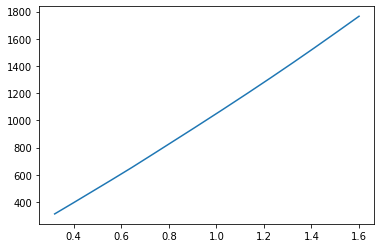

In [11]:
EOS_lin_ex = extend_EOS_cs(1e-4, cs2_lin)
tot_EOS_lin = stitch_EOS(EOS_small, EOS_lin_ex)

np.savetxt('../data/EOS_test_linear.dat', tot_EOS_lin)

plt.plot(EOS_lin_ex[:,0], EOS_lin_ex[:,2], '-')

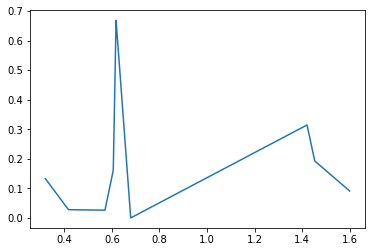

In [13]:
plt.plot(EOS_lin_ex[:,0], cs2_lin(EOS_lin_ex[:,0]))

In [14]:
import real_TOVsolver

max_pressure = 350 #MeV/fm3

MRL_lin = real_TOVsolver.solve(tot_EOS_lin, max_pressure)
np.savetxt('../data/MRL_lin.dat', MRL_lin)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


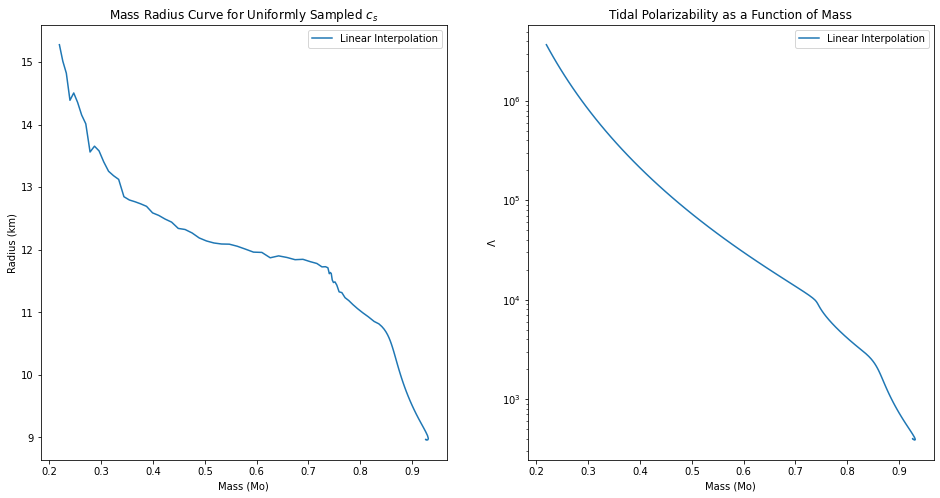

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_lin[:,0], MRL_lin[:,1], label='Linear Interpolation')
# ax[0].plot(MRL_cube[:,0], MRL_cube[:,1], label='Cubic Spline Interpolation')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Uniformly Sampled $c_s$')
ax[0].legend()

ax[1].plot(MRL_lin[:,0], MRL_lin[:,2], label='Linear Interpolation')
# ax[1].plot(MRL_cube[:,0], MRL_cube[:,2], label='Cubic Spline Interpolation')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

We want an interpolation method that also makes linear segments in the pressure $P(\epsilon)$. We can borrow the same idea we used to make linear segments in the speed of sound, pull random density points but also pull random pressures and sort them from loweset to highest (because we can't have the pressure decreasing).

In [21]:
def sample_P(num_points, n_start, max_n, p_start, max_p):
    
    # sample random points in density
    epsilon_n = 1e-7*n_start
    loc_n = n_start + epsilon_n #to guarentee we don't randomly pull n_start
    scale_n = max_n - n_start - epsilon_n
    sample_n = sts.uniform.rvs(loc=loc_n, scale=scale_n, size=num_points-1)
    # order these points
    n_sort = np.sort(sample_n)
    
    # sample speeds of sound
    epsilon_p = 1e-7*p_start
    loc_p = p_start + epsilon_p #to guarentee we don't randomly pull p_start
    scale_p = max_p - p_start - epsilon_p
    sample_p = sts.uniform.rvs(loc=loc_p, scale=scale_p, size=num_points-1)
    # order these points
    p_sort = np.sort(sample_p)
    
    # construct the arrays
    n_0 = n_start*np.ones(1)
    n = np.append(n_0, n_sort)
    ns = np.append(n, max_n)
    
    p_0 = p_start*np.ones(1)
    p = np.append(p_0, p_sort)
    ps = np.append(p, max_p)
    
    return ns, ps

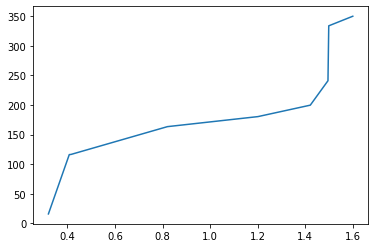

In [22]:
# parameters for sampling function
num_points = 8
n_start = n[-1]
max_n = 10*n0
p_start = p[-1]
max_p = max_pressure

ns, ps = sample_P(num_points, n_start, max_n, p_start, max_p)

P_lin = scipy.interpolate.interp1d(ns, ps)

plt.plot(ns, P_lin(ns))

In [23]:
def extend_EOS_Plin(n_step, P_lin):

    size = int((max_n-n_start)/n_step)

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0,0] = n_start
    EOS_ex[0,1] = p[-1]
    EOS_ex[0,2] = e[-1]

    for k in range(size-1):
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # p_i+1
        EOS_ex[k+1,1] = P_lin(EOS_ex[k+1,0])
        # e_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        
    return EOS_ex

In [27]:
EOS_linP_ex = extend_EOS_Plin(1e-3, P_lin)
EOS_linP = stitch_EOS(EOS_small, EOS_linP_ex)

MRL_linP = real_TOVsolver.solve(EOS_linP, max_pressure)
np.savetxt('../data/MRL_linP.dat', MRL_linP)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


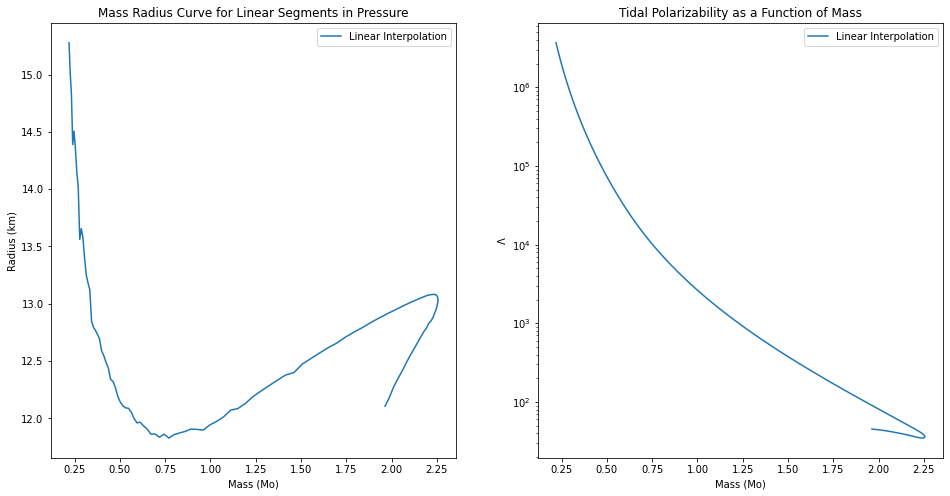

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_linP[:,0], MRL_linP[:,1], label='Linear Interpolation')
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Linear Segments in Pressure')
ax[0].legend()

ax[1].plot(MRL_linP[:,0], MRL_linP[:,2], label='Linear Interpolation')
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')
ax[1].legend()

Next we also want to implement segments of polytropic equations ($P = K\rho^\Gamma$). 